In [83]:
from pathlib import Path
import numpy as np
import supervision as sv
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
import pandas as pd

In [20]:
output_dir = Path('./output')
frames_dir = Path('./frames')
vid = "1024B_Avatar_bowling_cut"
frame_list = sorted(list((frames_dir/vid).glob("*.png")))
frame_dict = {frame.name:frame for frame in frame_list}
video_output_dir = output_dir/vid
video_output_dir.mkdir(exist_ok=True)

In [15]:
with open(output_dir/f"{vid}_anno.pkl",'rb') as f:
    annotations = pickle.load(f)

(array([  4.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   4.,   0.,   8.,
         22.,   5.,   6.,   3.,   6.,  20.,  18.,  60., 142.]),
 array([0.        , 0.0457619 , 0.0915238 , 0.13728569, 0.18304759,
        0.22880949, 0.27457139, 0.32033329, 0.36609519, 0.41185708,
        0.45761898, 0.50338088, 0.54914278, 0.59490468, 0.64066657,
        0.68642847, 0.73219037, 0.77795227, 0.82371417, 0.86947607,
        0.91523796]),
 <BarContainer object of 20 artists>)

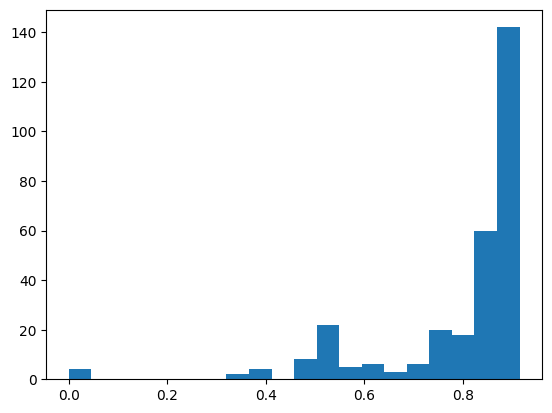

In [16]:
# condif_list = []
# for image_name,detections in annotations.items():
#     if len(detections.confidence) >0:
#         confid = max(detections.confidence)
#     else:
#         confid = 0.0
#     condif_list.append(confid)
# plt.hist(condif_list,bins=20)

In [69]:
for image_name,detections in tqdm(annotations.items()):
    img_path = frame_dict[image_name]
    if len(detections.confidence) ==0: continue
    image = cv2.imread(str(img_path))
    anno_id = np.argmax(detections.confidence)
    conf = detections.confidence[anno_id]
    if conf<=0.75: continue
    xyxy = detections.xyxy[anno_id]
    mask = detections.mask[anno_id]
    # crop_img = image[int(xyxy[1]):int(xyxy[3]),int(xyxy[0]):int(xyxy[2])]
    rgb_mask = np.stack((mask,)*3, axis=-1)
    mask_img = image*rgb_mask
    mask_img = mask_img[int(xyxy[1]):int(xyxy[3]),int(xyxy[0]):int(xyxy[2])]
    cropped_mask = mask[int(xyxy[1]):int(xyxy[3]),int(xyxy[0]):int(xyxy[2])]
    alpha = np.zeros_like(cropped_mask,dtype=np.uint8)
    alpha[cropped_mask==True] = 255
    result = cv2.cvtColor(mask_img,cv2.COLOR_BGR2BGRA)
    result[:,:,3] = alpha
    cv2.imwrite(str(video_output_dir/f'{image_name[:-4]}_mask.png'),result)

  0%|          | 0/300 [00:00<?, ?it/s]

In [92]:
def get_center(xyxy):
    v_center = (xyxy[3]+xyxy[1]) /2
    h_center = (xyxy[0]+xyxy[2]) / 2
    return int(v_center),int(h_center)
def cluster_to_label(centers):
    c2l_dict = {}
    c2l_dict[int(np.min(centers))] = 'detail'
    c2l_dict[int(np.max(centers))] = 'menu'
    c2l_dict[int(np.median(centers))] = 'avatar'
    return c2l_dict
image_ids = []
centers = []
for image_name,detections in tqdm(annotations.items()):
    if len(detections.confidence) ==0: continue
    anno_id = np.argmax(detections.confidence)
    conf = detections.confidence[anno_id]
    if conf<=0.75: continue
    xyxy = detections.xyxy[anno_id]
    image_ids.append(image_name)
    centers.append(get_center(xyxy))
km = KMeans(n_clusters=3,n_init="auto")
centers = np.array(centers)
km.fit(centers[:,1].reshape((-1,1)))
all_cluster_center = km.cluster_centers_[km.predict(centers[:,1].reshape((-1,1)))]
c2l_dict = cluster_to_label(km.cluster_centers_)
viewport = [c2l_dict[int(center[0])] for center in all_cluster_center]
df = pd.DataFrame(data={'frame':image_ids,'viewport':viewport})

  0%|          | 0/300 [00:00<?, ?it/s]

In [101]:
df.to_csv(output_dir/f"{vid}_result.csv",index=False)